<a href="https://colab.research.google.com/github/AleemRahil/Robust-End-to-End-E-Commerce-Analytics-Automation-with-LLMs/blob/main/ecommerce_customer_tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Static Customer Tagging in Shopify
Use OpenAI and the Shopify API to create basic customer tags and personas. By effectively utilizing customer tags, ecommerce businesses can enhance their targeted marketing strategies, boost customer engagement, and ultimately drive sales.

In this project, I will start developing the code needed to tag customers for personalization in Shopify. Specifically, I will show how to extract static tags from the Shopify Customer and Order objects and use those tags to create customer personas. We are going to cover the following

What is Customer Tagging?

Extracting Static Customer Tags in Shopify

Advanced Tagging with LLMs

Tagging Shopify Customers with GraphQL

Where to use Customer Tags For Personalization


So what is customer tagging, and how do you extract business value from it?

#What is Customer Tagging?
A customer tag is a specific attribute or property assigned to a customer within an ecommerce backend system or Email Service Provider (ESP). These tags enable businesses to categorize, filter, and tailor communications based on distinct customer characteristics. Understanding the difference between static and dynamic tags is fundamental for effective customer segmentation and personalized marketing strategies.

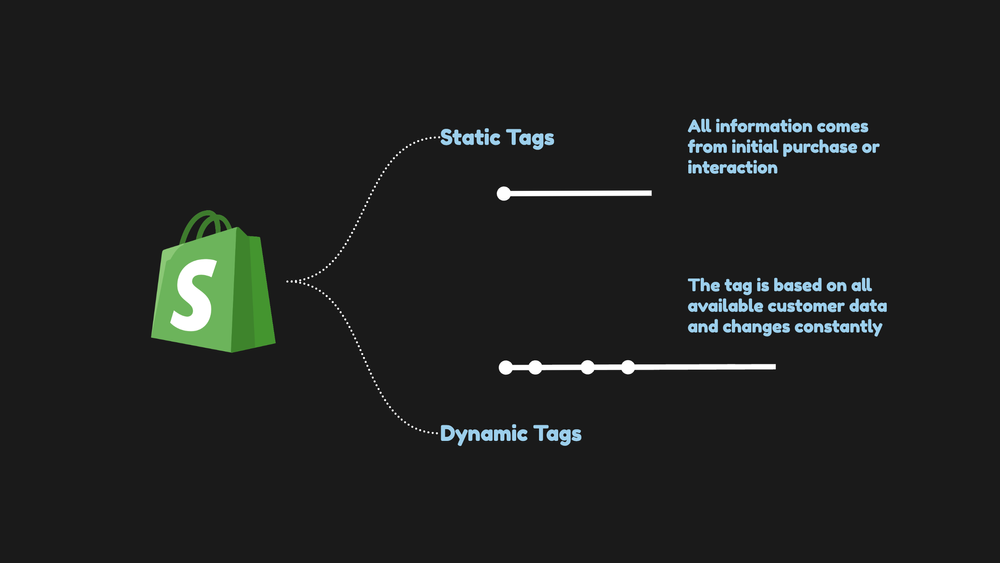

#Static Tags
Static tags refer to customer properties that remain consistent over time. These attributes are fixed and provide a snapshot of a customer's profile at the entry point or based on historical data. Examples of static tags include:

Age or Generation: Demographic data categorizes customers into generational groups (Baby Boomers, Millennials, etc.).

Gender: The customer's gender.

First Product Purchased: The initial item the customer buys from the business.
Discount on First Product: Any discount applied to the first purchase.
Online Purchase vs In-Store: The channel through which customers make their first purchase.

Time from First Recorded Visit to Purchase: This is sometimes called buyer inertia. It measures the duration between a customer's first visit and purchase.

Time-Based Cohorts: The month and year they made their first purchase.
Number of Products in First Order: The total items included in the customer's initial order.

Order Value in First Order: The total monetary value of the first order.
These tags help you identify foundational elements of a customer's relationship with your brand.

#Dynamic Tags
In contrast, dynamic tags are attributes that evolve, reflecting the changing nature of a customer's interaction with a brand. These can include straightforward metrics and more complex, calculated, or predicted properties.

Examples of dynamic tags include:

AOV: The average monetary value a customer spends per order.

Number of Orders: Number of orders placed by a customer over time.

CLV: An estimate of the total value a customer will bring to your business throughout their relationship.

The Last Product Purchased: The most recent item bought by the customer.

Customer Discount Sensitivity: A measure of how responsive a customer is to discounts and promotions.

Churn Propensity: The likelihood that a customer will stop purchasing from your brand.

Propensity to become VIP: The potential for a customer to become a high-value or VIP customer based on their purchasing habits.

Purchase Cadence: When a customer will likely make their next purchase.

Predicted Persona Category: An LLM-driven guess of what persona category/categories the customer belongs to.

When designing customer engagement strategies, both dynamic and static tags play an important role. These tags help businesses adapt their marketing efforts according to customer behavior patterns. With customer tags, businesses can more easily build targeted marketing strategies, boost customer engagement, and ultimately drive sales.

First, we install necessary Python packages for interacting with Shopify API, dotenv for managing environment variables, and OpenAI for accessing GPT models.

In [ ]:
!pip install -qU \
  python-dotenv \
  openai \
  ShopifyAPI

Next, we import the required libraries. dotenv is used to load environment variables, and shopify for Shopify API interactions. openai is used for accessing OpenAI's API.

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

We initialize a Shopify session using the merchant name, API version, and access token stored in environment variables.

In [ ]:
import shopify

merchant= os.getenv('SHOPIFY_MERCHANT')
token = os.getenv('SHOPIFY_TOKEN')
api_session = shopify.Session(merchant, '2023-01', token)
shopify.ShopifyResource.activate_session(api_session)

In [ ]:
from openai import OpenAI
client = OpenAI()

#Extracting Static Tags from Shopify Data
Let's look at how we extract static customer tags in Shopify. To fetch static tags, we can leverage the Shopify GraphQL API to access customer and order information, including the "CustomerJourneySummary" for insights on the time to the first purchase.

We'll construct a GraphQL query fetching all orders for a customer and then extracting static tag information (such as First Product Purchased, Discount on First Product, Time from First Recorded Visit to Purchase, and Order Value in First Order) from those orders. We can break down the solution into two functions:

Fetch all orders for a customer: This function will retrieve all orders associated with a specific customer ID.
Extract static tags from orders: Given the list of orders, this function will extract and compile the static tag information from the first order (assuming the static tags are primarily derived from the first purchase).
We'll start by fetching all customer orders:

The following function queries Shopify to fetch all orders made by a specific customer. It constructs a GraphQL query to retrieve detailed information about each order, including line items and customer journey summary.

In [ ]:
def fetch_all_customer_orders(customer_id):
    """
    Fetch all orders for a customer from Shopify.

    :param customer_id: ID of the customer
    :return: A list of orders
    """
    query = f"""
    {{
      customer(id: "gid://shopify/Customer/{customer_id}") {{
        orders(first: 250) {{
          edges {{
            node {{
              id
              createdAt
              lineItems(first: 250) {{
                edges {{
                  node {{
                    title
                    originalTotalPriceSet {{
                      shopMoney {{
                        amount
                        currencyCode
                      }}
                    }}
                    discountAllocations {{
                      allocatedAmountSet {{
                        shopMoney {{
                          amount
                          currencyCode
                        }}
                      }}
                    }}
                  }}
                }}
              }}
              totalPriceSet {{
                shopMoney {{
                  amount
                  currencyCode
                }}
              }}
              customerJourneySummary {{
                daysToConversion
                firstVisit {{
                  occurredAt
                  source
                  referrerUrl
                }}
              }}
            }}
          }}
        }}
      }}
    }}
    """

    client = shopify_client(merchant, token)
    result = client.execute(query)
    return json.loads(result)['data']['customer']['orders']['edges']

Next, we need a function that processes the list of orders fetched to extract static tags from the first order.

Then we extract static tags from the fetched orders, which can be used for customer segmentation or analysis.

In [ ]:
def extract_tags(orders, info=None):
    """Extracts static tags from orders."""
    if not orders: return "No orders."
    order = orders[0]['node']
    items = order['lineItems']['edges']
    product = discount = value = days = name = "Not available"

    if items:
        product = items[0]['node']['title']
        discounts = items[0]['node'].get('discountAllocations', [])
        if discounts:
            discount = discounts[0]['allocatedAmountSet']['shopMoney']['amount']

    value = order['totalPriceSet']['shopMoney']['amount']
    summary = order.get('customerJourneySummary')
    if summary: days = summary['daysToConversion']
    if info:
        name = f"{info.get('firstName', '')} {info.get('lastName', '')}".strip()
    elif 'customer' in order:
        customer = order['customer']
        name = f"{customer.get('firstName', '')} {customer.get('lastName', '')}".strip()

    return {
        "Name": name, "First Product": product, "Discount": discount,
        "Order Value": value, "Days to Conversion": days
    }


To use these functions, you would first fetch all orders for a customer fetch_all_customer_orders(customer_id) and then pass the result to extract_tags(orders) to get the static tags from the first order.

Now we can extract the static tags from the customer data

In [ ]:
customer_id = '1234567890'
orders = fetch_all_customer_orders(customer_id)
static_tags = extract_tags(orders)
print(static_tags)

These functions specifically target the first order made by a customer. They extract details about the first product purchased, any discount applied to it, the total value of the first order, and the time from the customer's first recorded visit to their purchase (days to conversion), utilizing the customerJourneySummary for insights on the customer's journey.

Next we open the personas.txt file

In [ ]:
with open('personas.txt', 'r') as file:
    base_personas = file.read()
print(base_personas)

1. Young Professional Male: Age 25-35, interested in looking stylish yet comfortable for his daily commute and office environment. He values quality and brand reputation. His goal is to maintain a professional image while expressing his personal style.

2. Fitness Enthusiast Female: Age 20-30, she is a regular gym-goer and values athletic wear that is both functional and fashionable. Her goal is to stay fit and look good while doing it.

3. Trendy Teenager: Age 13-19, this persona is very interested in the latest trends and what their peers are wearing. They value affordability and the 'cool' factor. Their goal is to fit in and express their developing personal style.

4. Stylish Mum: Age 30-40, she is interested in looking fashionable while being able to comfortably manage her active kids. She values durability and versatility in clothing. Her goal is to maintain her sense of style while being a busy mum.

5. Sporty Kid: Age 6-12, interested in sports and outdoor activities. They valu

We use an OpenAI model to analyze the customer data and generate a persona based on the extracted tags and other information.

#Advanced Tagging With LLMs
Incorporating customer behavior and purchase history into GPT-4 prompts allows for the dynamic generation of insights regarding customer demographics, interests, and preferences, updating persona categories in real time as new data becomes available.

This method involves extracting key customer information from Shopify, like purchase history and engagement metrics, and feeding it into GPT-4. The model then categorizes customers into personas based on their behaviors. For instance, it might identify personas focused on discount sensitivity or consistent purchasing patterns.

I will categorize each customer into a group based on the following personas. These personas serve as a foundational framework to understand customer preferences, behaviors, and needs more deeply.

By aligning customers with these distinct profiles, we can tailor our marketing strategies, product recommendations, and overall customer engagement to better meet the unique demands of each segment.

Here are the first 5 personas of the 20 personas we're going to use:

Young Professional Male: Age 25-35, interested in looking stylish yet comfortable for his daily commute and office environment. He values quality and brand reputation. His goal is to maintain a professional image while expressing his personal style.
Fitness Enthusiast Female: Age 20-30, she is a regular gym-goer and values athletic wear that is both functional and fashionable. Her goal is to stay fit and look good while doing it.
Trendy Teenager: Age 13-19, this persona is very interested in the latest trends and what their peers are wearing. They value affordability and the 'cool' factor. Their goal is to fit in and express their developing personal style.
Stylish Mum: Age 30-40, she is interested in looking fashionable while being able to comfortably manage her active kids. She values durability and versatility in clothing. Her goal is to maintain her sense of style while being a busy mum.
Sporty Kid: Age 6-12, interested in sports and outdoor activities. They value comfort and fun designs in their clothing. Their goal is to have fun and be comfortable while playing.

We can now place the customer in a persona category by using the information captured in static tags. This data, along with a set of base personas, is then fed to GPT-4.



In [ ]:
persona_prompt = f'''
I have a customer described by the data here '{tags}'.
Here's a reference list of Persona categories {base_personas}

Give your best guess of age and gender based on the customer name.

Return the following:

- Name
- Persona category name
- General interests
- Behaviour
- Age
- Gender

Don't explain why just return it as a JSON object.
'''

openai_response = client.chat.completions.create(
    model='gpt-4-0125-preview',
    messages=[{'role': 'user', 'content': persona_prompt}],
    response_format={"type": "json_object"}
)

persona = openai_response.choices[0].message.content

print(persona)

This will give us a JSON object in return that we can use for adding additional tags to the customer.

Finally, we update the customer's tags in Shopify based on the generated persona, enriching the customer profile for personalized marketing or insights.

#Tagging Customers in Shopify

We can now tag customers with static tags and persona tags by executing a GraphQL mutation with the tags as an argument:

In [ ]:
def update_tags(merchant, token, customer_id, tags, persona_json):
    client = shopify_client(merchant, token)
    persona = json.loads(persona_json)
    p_tag = persona.get('persona', None)
    if p_tag:
        tags = list(set(tags + [p_tag]))  # Combine & deduplicate
        mutation = """
        mutation($id: ID!, $tags: [String!]!) {
          customerUpdate(input: {id: $id, tags: $tags}) {
            customer { id tags }
            userErrors { field message }
          }
        }"""
        res = client.execute(mutation, {"id": f"gid://shopify/Customer/{customer_id}", "tags": tags})
        print(res)
    else:
        print("No persona tag.")

This function converts the JSON response to extract the 'persona' key, ensuring that new insights are integrated with existing customer tags. This prevents data duplication and keeps the customer tag fields orderly and clean.

Once we have tags in the system, we need to use these tags to create business value.

#Getting Business Value Out Of Customer Tags

For e.g. When using Klaviyo as an ESP alongside Shopify, any tags assigned to customer profiles in Shopify are automatically transferred to Klaviyo. This synchronization enables the creation of specific segments based on those tags. Consequently, tagging customers in Shopify facilitates the tailoring of email flows and campaigns in Klaviyo.

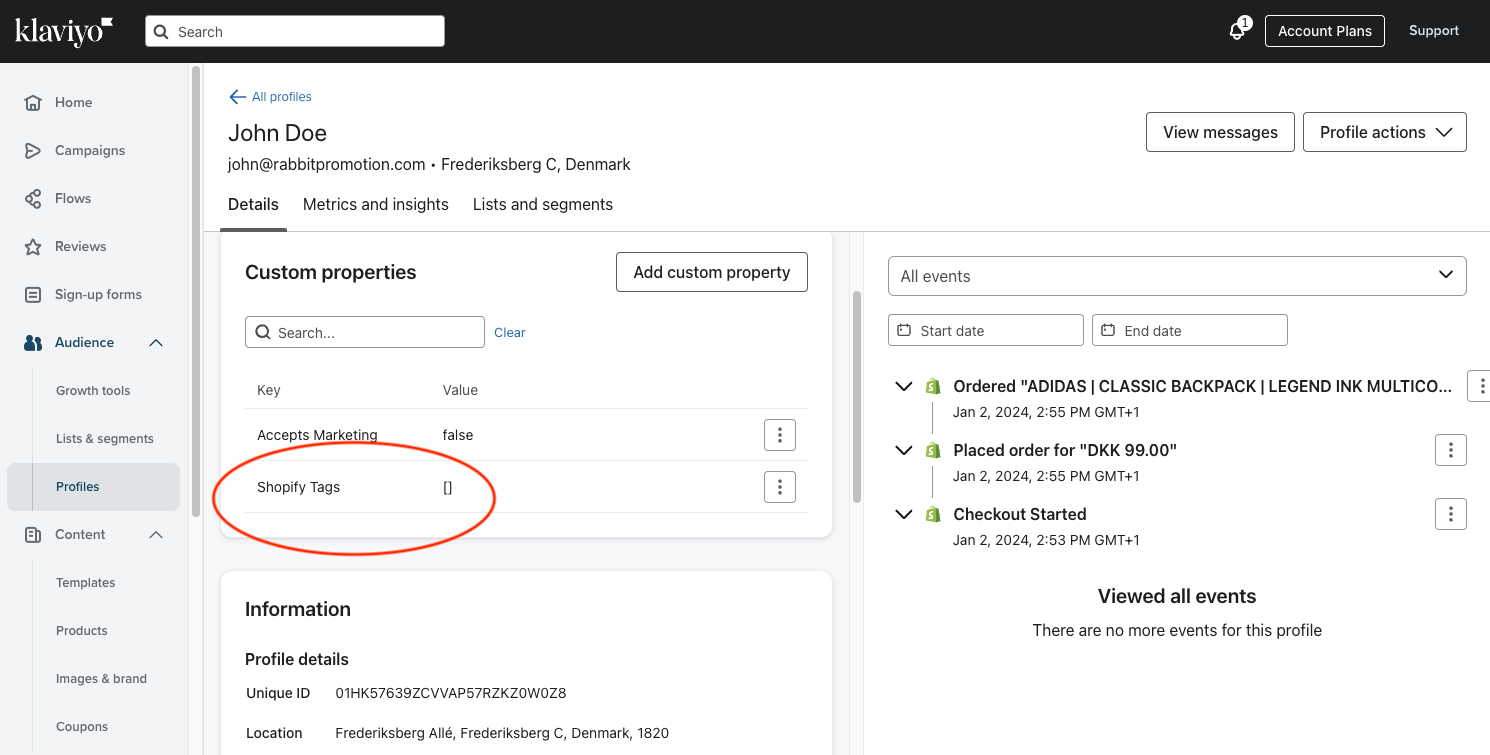

Another way we can use the tags is when the customer is logged into Shopify. This situation allows for real-time personalization since the customer object is directly accessible, enabling us to display content, offers, or recommendations that resonate with the tags associated with their profile.

For instance, if a customer has the tag "newsletter", as shown in the image, we could prioritize showing them products featured in the newsletter, making the customer experience more coherent across touchpoints.

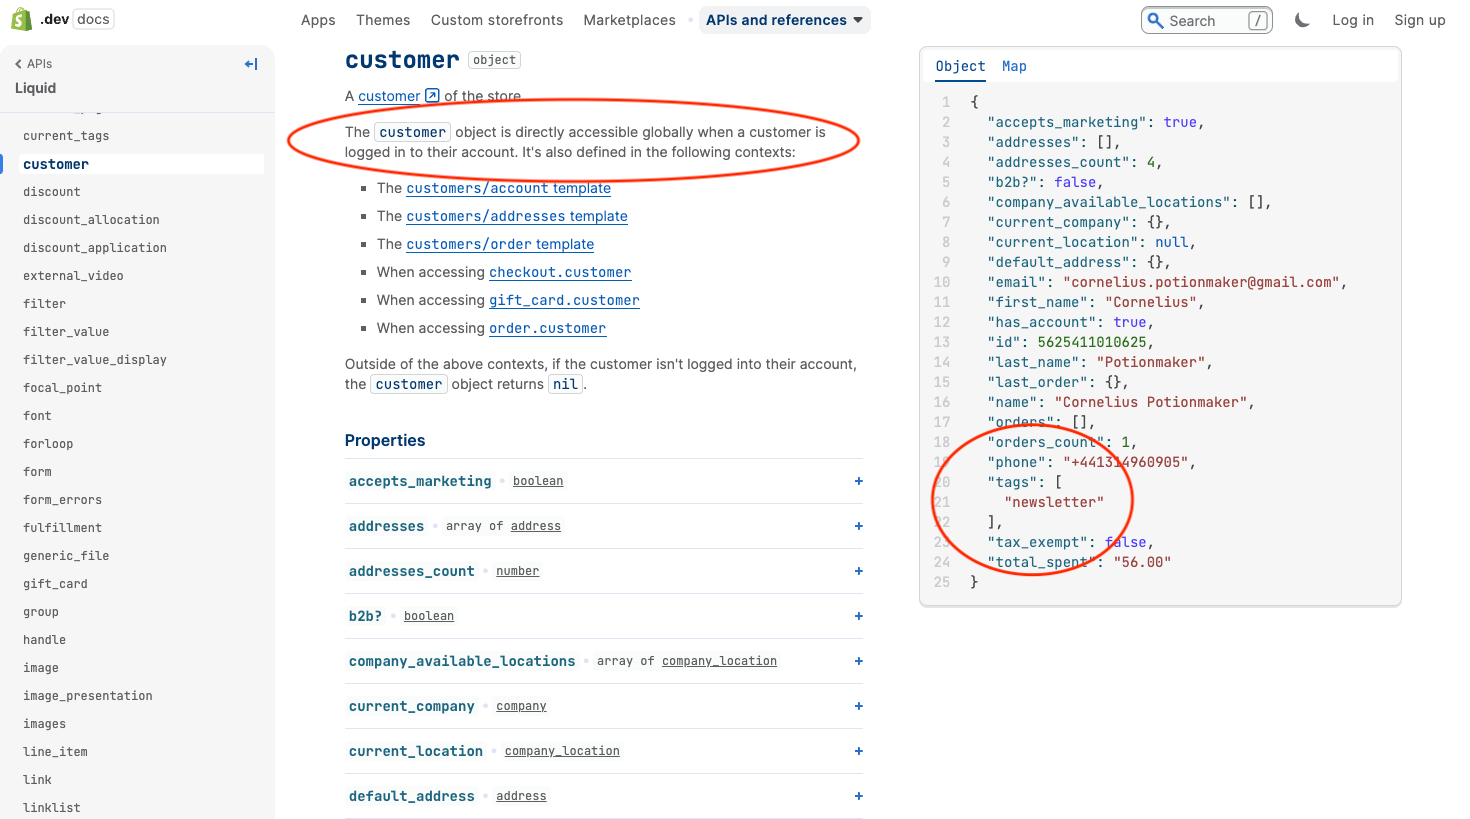

Leveraging the customer object in Shopify, especially with Klaviyo, merchants can significantly improve the customer experience. By using customer tags for personalized content, targeted promotions, and segmented email campaigns, merchants can create a highly tailored experience that resonates with the individual needs and preferences of their customers.